In [70]:
import yaml
import pandas as pd
import time
import joblib
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler


with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"

training_file_path: str = f"../data/twelvedata/feature time series ({interval})/MSFT_feature_time_series.csv"
validation_file_path: str = f"../data/twelvedata/feature time series ({interval})/AAPL_feature_time_series.csv"

start_time = time.time()
pd.set_option('display.max_columns', None)

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)

training_df

,datetime,open,open change,open change (%),open trend,high,high change,high change (%),high trend,low,low change,low change (%),low trend,close,close change,close change (%),close trend,volume,sma,sma change,sma change(%),sma trend,ema,ema change,ema change(%),ema trend,price movement,price range,price trend,percent_b,atr,macd,macd_signal,macd_hist,adx,rsi,%K,%D,vpt,day,hour
0,2021-03-15 09:30:00,234.90,-0.48,-0.0020,0,235.18,-0.64,-0.0027,0,232.50,-2.62,-0.0111,0,232.74,-3.06,-0.0130,0,5520872,234.9911,-0.5889,-0.0025,0,234.9911,-0.5889,-0.0025,0,-2.16,2.68,0,0.173800,1.7762,0.5752,1.0593,-0.4840,29.8008,42.4837,3.5982,31.2362,1.740434e+05,0,9
1,2021-03-15 10:30:00,232.75,-2.15,-0.0092,0,233.40,-1.78,-0.0076,0,232.25,-0.25,-0.0011,0,232.48,-0.26,-0.0011,0,3450653,234.4600,-0.5311,-0.0023,0,234.4600,-0.5311,-0.0023,0,-0.27,1.15,0,0.168777,1.7315,0.3258,0.9126,-0.5868,28.5319,41.5258,3.3237,16.7293,1.701886e+05,0,10
2,2021-03-15 11:30:00,232.48,-0.27,-0.0012,0,233.08,-0.32,-0.0014,0,231.82,-0.43,-0.0019,0,232.72,0.24,0.0010,1,2597786,234.3089,-0.1511,-0.0006,0,234.3089,-0.1511,-0.0006,0,0.24,1.26,1,0.209748,1.6978,0.1457,0.7592,-0.6135,27.5926,42.8077,12.2449,6.3889,1.728705e+05,0,11
3,2021-03-15 12:30:00,232.68,0.20,0.0009,1,233.12,0.04,0.0002,1,232.49,0.67,0.0029,1,232.93,0.21,0.0009,1,1711292,234.1578,-0.1511,-0.0006,0,234.1578,-0.1511,-0.0006,0,0.25,0.63,1,0.226476,1.6216,0.0198,0.6113,-0.5915,26.6891,43.9653,15.8571,10.4752,1.744147e+05,0,12
4,2021-03-15 13:30:00,232.92,0.24,0.0010,1,233.47,0.35,0.0015,1,232.56,0.07,0.0003,1,233.30,0.37,0.0016,1,1776966,233.9500,-0.2078,-0.0009,0,233.9500,-0.2078,-0.0009,0,0.38,0.91,1,0.264726,1.5707,-0.0496,0.4791,-0.5287,25.5666,46.0377,22.6994,16.9338,1.772373e+05,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,2024-01-09 11:30:00,374.32,2.53,0.0068,1,375.77,1.26,0.0034,1,374.03,2.37,0.0064,1,375.28,0.96,0.0026,1,1707615,373.0067,0.5745,0.0015,1,373.0067,0.5745,0.0015,1,0.96,1.74,1,0.948215,1.8899,0.8214,0.1695,0.6518,15.9006,61.3674,94.7141,81.5714,4.815495e+06,1,11
4966,2024-01-09 12:30:00,375.25,0.93,0.0025,1,375.99,0.22,0.0006,1,375.06,1.03,0.0028,1,375.15,-0.13,-0.0003,0,1525737,373.5633,0.5566,0.0015,1,373.5633,0.5566,0.0015,1,-0.10,0.93,0,0.884185,1.8213,0.9648,0.3286,0.6363,15.9653,60.8573,91.1486,91.9159,4.814966e+06,1,12
4967,2024-01-09 13:30:00,375.15,-0.10,-0.0003,0,375.61,-0.38,-0.0010,0,374.34,-0.72,-0.0019,0,375.02,-0.13,-0.0003,0,1358266,373.9978,0.4345,0.0012,1,373.9978,0.4345,0.0012,1,-0.13,1.27,0,0.833640,1.7819,1.0559,0.4741,0.5819,15.6104,60.3173,89.7787,91.8805,4.814495e+06,1,13
4968,2024-01-09 14:30:00,375.05,-0.10,-0.0003,0,375.49,-0.12,-0.0003,0,374.65,0.31,0.0008,1,375.13,0.11,0.0003,1,2060258,374.3733,0.3755,0.0010,1,374.3733,0.3755,0.0010,1,0.08,0.84,1,0.811518,1.7147,1.1240,0.6040,0.5199,15.2808,60.6355,90.9378,90.6217,4.815100e+06,1,14


In [71]:
import numpy as np
lookback_period: int = config['preprocess']['lookback_period']
target_column: str = config['preprocess']['target_column']
trend_length: int = config['preprocess']['trend_length']
training_preprocessor = DataPreprocessor(stock_time_series=training_df, lookback_period=lookback_period, target_column=target_column, trend_length=trend_length)
validation_preprocessor = DataPreprocessor(stock_time_series=validation_df, lookback_period=lookback_period, target_column=target_column, trend_length=trend_length)

X_train = training_preprocessor.target_data_batched
y_train = training_preprocessor.target_data_batched_labels

X_val = validation_preprocessor.target_data_batched
y_val = validation_preprocessor.target_data_batched_labels

print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)

end_time = time.time()
loading_time = end_time - start_time
print("Loading time: ", loading_time)



Training Dataset shape: (4970, 41)
Validation Dataset shape: (4970, 41)
Loading time:  1.2040038108825684


In [72]:
# for column in training_preprocessor.target_data.columns:
    # print(column)
    # print(training_preprocessor.target_data[column].isnull().sum())
    # print(training_preprocessor.target_data[column].isin([np.inf, -np.inf]).sum())
test = training_preprocessor.target_data[['close', 'ema', 'target']]
condition1 = test['target'] == 1
condition2 = test['close'] < test['ema']

combined = condition1 & condition2
tester = test[combined]
print(tester.shape[-2])
print(tester.shape[-2] / training_df.shape[-2])
tester

408
0.08209255533199195


,close,ema,target
datetime,,,
2021-03-19 15:30:00,229.91,230.9411,1
2021-03-23 14:30:00,238.02,238.5833,1
2021-03-24 09:30:00,235.74,238.6589,1
2021-03-29 09:30:00,232.09,233.9922,1
2021-03-29 11:30:00,233.53,234.1544,1
...,...,...,...
2023-12-26 12:30:00,373.96,374.3789,1
2023-12-29 11:30:00,373.69,375.2800,1
2023-12-29 12:30:00,375.26,375.3167,1


In [73]:

X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)


Training sets shape: (4959, 9, 42) (4959,)
Validation sets shape: (4959, 9, 42) (4959,)


In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_filename: str = "scaler.save"
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

In [75]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()

Total number of weights in the model: 2061
Epoch 1/50
155/155 [==============================] - 6s 17ms/step - loss: 0.6519 - accuracy: 0.6398 - val_loss: 0.6178 - val_accuracy: 0.6874
Epoch 2/50
155/155 [==============================] - 2s 11ms/step - loss: 0.5771 - accuracy: 0.7130 - val_loss: 0.5517 - val_accuracy: 0.7366
Epoch 3/50
155/155 [==============================] - 2s 11ms/step - loss: 0.4912 - accuracy: 0.7860 - val_loss: 0.4598 - val_accuracy: 0.7979
Epoch 4/50
155/155 [==============================] - 2s 11ms/step - loss: 0.4344 - accuracy: 0.8167 - val_loss: 0.4114 - val_accuracy: 0.8185
Epoch 5/50
155/155 [==============================] - 2s 11ms/step - loss: 0.4158 - accuracy: 0.8268 - val_loss: 0.3923 - val_accuracy: 0.8250
Epoch 6/50
155/155 [==============================] - 2s 11ms/step - loss: 0.4020 - accuracy: 0.8268 - val_loss: 0.3787 - val_accuracy: 0.8344
Epoch 7/50
155/155 [==============================] - 2s 11ms/step - loss: 0.3946 - accuracy: 0.835

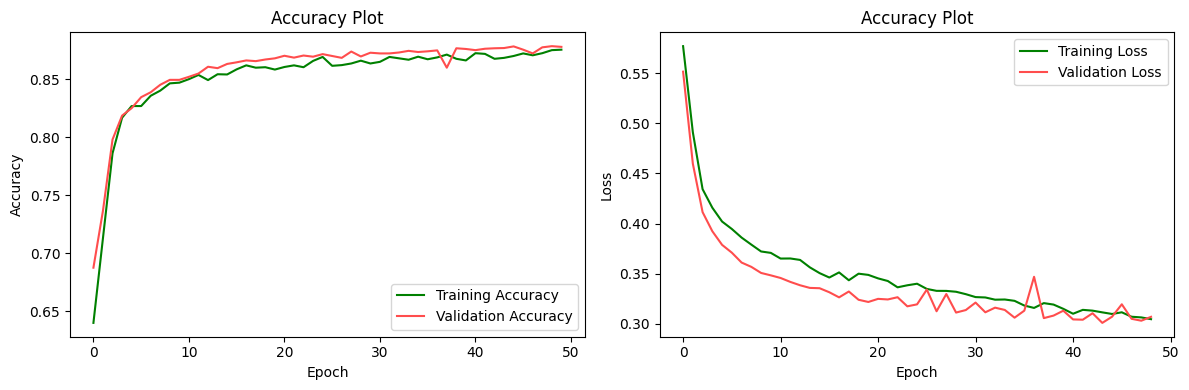

In [76]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)